# Flight Data Analysis - Airbus

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import scipy
from scipy.stats import norm
import warnings

## I. Data Set

In [2]:
file_location = "../DataSet/Dataset_ter.xlsx"
#"../DataSet/INSA-AirbusFHS-DatasetPN_D-E-F.xlsx"
#"../DataSet/Dataset_ter.xlsx"

##### Data preprocessing :

In [3]:
def preprocessing(file_location):
    # Import data
    Removals = pd.read_excel(file_location, sheet_name='Removals')
    SNlist = pd.read_excel(file_location, sheet_name='SN list')
    airlines = pd.read_excel(file_location, sheet_name='Airlines')

    # Combining Removals and SNlist :
    fail_and_not = SNlist.copy()
    fail_and_not['On_Aircraft'] = False
    onaircraft_fan = fail_and_not['On_Aircraft']
    with warnings.catch_warnings():
        warnings.filterwarnings("ignore")
        onaircraft_fan[fail_and_not['Current SN Status Description']=='On Aircraft']=True
    fail_and_not['On_Aircraft'] = onaircraft_fan
    fail_and_not['failed'] = False
    failed_fan = fail_and_not['failed']
    with warnings.catch_warnings():
        warnings.filterwarnings("ignore")
        failed_fan[fail_and_not['Current SN Status Description']=='In Outside Repair']=True
    fail_and_not['failed'] = failed_fan
    fail_and_not = fail_and_not.drop(['Description','Current SN Status Description','Since New Date'], axis = 1)
    fail_and_not = fail_and_not.rename(columns={"Part Number": "PN", "Serial Number": "SN", "Hour ageing Since Installation": "TSI", "Hour ageing Since New": "TSN"})

    fail = Removals.copy()
    fail['On_Aircraft'] = False
    fail['failed'] = True
    failed_f = fail['failed']
    with warnings.catch_warnings():
        warnings.filterwarnings("ignore")
        failed_f[fail['Maintenance Type']=='Scheduled'] = False
    fail['failed'] = failed_f
    fail = fail.drop(['Removal date','Description','Maintenance Type'], axis=1)
    fail = fail.rename(columns={"P/N": "PN", "S/N": "SN", "TSI (Flight Hours) at removal": "TSI", "TSN (Flight Hours) at Removal": "TSN", "Customer":"Company"})

    all_SN = pd.unique(fail_and_not['SN'])
    SN_Removals = pd.unique(fail['SN'])

    combined = pd.concat([fail,fail_and_not], ignore_index=True)
    combined = combined.drop_duplicates(subset=['SN','PN','TSN'], keep='last')

    # Data errors treatment
    combined['TSI']=combined['TSI'].replace(np.nan, 0.0)
    combined['TSN']=combined['TSN'].replace(np.nan, 0.0)
    combined['Company']=combined['Company'].replace('1', 1)
    combined['Company']=combined['Company'].replace('3', 3)
    combined = combined[combined['TSN']!=0]
    return combined, airlines

In [4]:
combined, airlines = preprocessing(file_location)
types = pd.unique(combined["PN"])
types = types[np.logical_not(pd.isnull(types))]
print("Unit types :",types)
combined.head()

Unit types : ['C' 'B' 'A' 'C-new']


,Company,PN,SN,TSI,TSN,On_Aircraft,failed
0,3,C,15323054356,5819.0,5819.0,False,True
1,3,C,15323057041,5819.0,5819.0,False,True
2,3,C,15323072973,3036.0,3036.0,False,True
3,3,C,15323053425,5614.0,5614.0,False,True
4,3,C,15323058236,5614.0,5614.0,False,True


In [5]:
print(len(set(combined['SN'])),'/',len(combined), 'distinct SN.')

6010 / 7774 distinct SN.


## II. Data Analysis

In [6]:
data = combined.copy()
alpha = 0.05 # coefficient related to confidence levels

In [7]:
data_types = {}
for typ in types:
    data_types[typ] = data[data['PN']==typ]

In [8]:
def time_sticker(data_type): 
    T = data_type.TSI.to_numpy(dtype="float")
    d = np.array([1 if f == True else 0 for f in data_type.failed])
    return T,d

### 1. Nelson-Aalen and Kaplan-Meier estimators

We first consider the Nelson-Aalen estimator and the Kaplan-Meier estimator which will be used to compare with the model we apply for data in each cases.

(Note that we need to install the "lifelines" package for Python).

In [9]:
from lifelines import KaplanMeierFitter
from lifelines import NelsonAalenFitter

def NAF(typ,df=data_types): # Nelson_Aalen model
    data_type = df[typ]
    T,d=time_sticker(data_type)
    label = "NA-estimator of type " + typ
    return NelsonAalenFitter().fit(T,d,alpha=alpha,label=label)

def KMF(typ,df=data_types): # Kaplan_meier model
    data_type = df[typ]
    T,d=time_sticker(data_type)
    label = "KM-estimator of type " + typ
    return KaplanMeierFitter().fit(T,d,alpha=alpha,label=label)

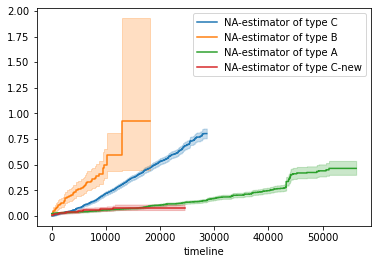

In [10]:
for typ in types:
    NAF(typ).plot(ci_show=True)

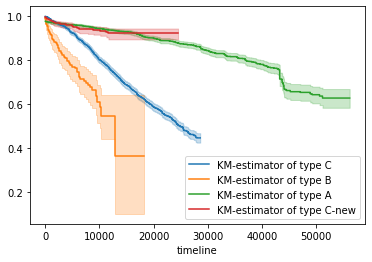

In [11]:
for typ in types:
    KMF(typ).plot(ci_show=True)

### 2. Parametric models

Find best parametric model

In [12]:
from lifelines.utils import find_best_parametric_model

def best_parametric_model(typ,df=data_types): # find the best parametric model which bases in AIC (or BIC as we can change scoring_method="BIC") method.
    data_type = df[typ]
    T,d=time_sticker(data_type)
    T[T==0]=1e-6 # Avoid divising by zero.
    tau=1-sum(d)/len(d)
    if tau>0.9:
        warnings.warn("There are more 90% censored data in type {} data. The applied model might not be correct!".format(str(typ)))
    best_model = find_best_parametric_model(T, d, scoring_method="AIC")[0]
    return best_model

Plotting best parametric model and KM-estimator:

In [13]:
def R_plot(typ): # We visualize if the best parametric model can fit the data of type "typ"
    m = best_parametric_model(typ)
    m.survival_function_.plot()
    KMF(typ).plot()
    plt.ylabel('Reliability function')
    plt.xlabel('Timeline')
    plt.title('Type ' + typ + ' data')

C:\Users\Nghi Truyen\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: UserWarning: There are more 90% censored data in type C-new data. The applied model might not be correct!
  if __name__ == '__main__':


KeyboardInterrupt: 

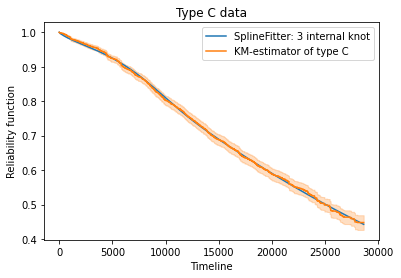

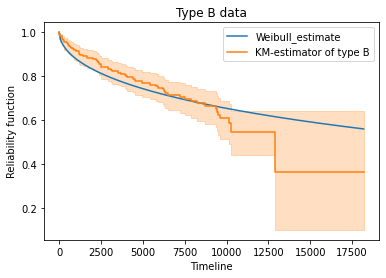

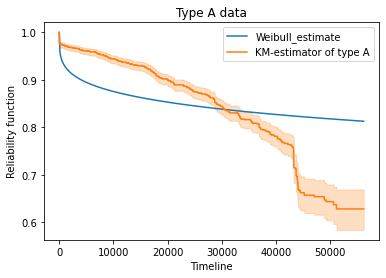

In [14]:
for typ in types:
    R_plot(typ)

## III. Homogeneity test of old vs new

In order for this to work, we need to separate old parts from new ones then do a logrank test

In [ ]:
from lifelines.statistics import logrank_test

def old_vs_new(typ,df=data_types):
    data_type = df[typ]
    new_or_not = data_type["TSI"]==data_type["TSN"]
    old = data_type[new_or_not==False]
    new = data_type[new_or_not==True]
    results = logrank_test(old["TSI"], new["TSI"], event_observed_A=old["failed"], event_observed_B=new["failed"])
    return results,(len(old.to_numpy()), len(new.to_numpy()))

In [ ]:
for typ in types:
    print("Type %s unit test:"%typ)
    res,n = old_vs_new(typ)
    print("%d old parts vs %d new parts"%n)
    print("p_valeur = ", res.p_value)
    res.print_summary()

In [ ]:
for typ in types:
    new_or_not = data_types[typ].TSI==data_types[typ].TSN
    
    T_old = data_types[typ][new_or_not==False]
    d_old = np.array([1 if f == True else 0 for f in T_old.failed])
    T_old = T_old.TSI.to_numpy(dtype="float")
    
    T_new = data_types[typ][new_or_not==True]
    d_new = np.array([1 if f == True else 0 for f in T_new.failed])
    T_new = T_new.TSI.to_numpy(dtype="float")
    
    KaplanMeierFitter().fit(T_new,d_new,alpha=alpha,label="New of type "+typ).plot(ci_show=False)
    KMF(typ).plot()
    KaplanMeierFitter().fit(T_old,d_old,alpha=alpha,label="Old of type "+typ).plot(ci_show=False)
    plt.show()

## IV. Simulation and stock optimization 

In [ ]:
list_company = pd.unique(airlines["Company"])
list_company = list_company[np.logical_not(pd.isnull(list_company))]
print("List of companies :",list_company)
airlines

Simulation from parametric law

The idea is: for each individual SN, we simulate the number of time it will fail till the end of contract, then for large number of SN, we repeat that simulation for each individual to calculate the sum.

Simulation from kaplan Meier

In [ ]:
def inverse_sampling(kapmei, timeline):
    u = np.random.uniform()
    if u < kapmei[-1]:
        T = -1
    elif u > kapmei[0]:
        T = 0
    else:
        arg = np.argmax(kapmei<=u)-1
        T = float(timeline[arg]+(timeline[arg+1]-timeline[arg])*(kapmei[arg]-u)/(kapmei[arg]-kapmei[arg+1]))
    return T

def conditional_inverse_sampling(kapmei, timeline, TSI):
    T = 0
    while T<=TSI and T>=0:
        T = inverse_sampling(kapmei, timeline)
    return T-TSI

def num_of_fails_indivi_kapmei(TSI, T, kapmei, timeline):    
    t = conditional_inverse_sampling(kapmei, timeline, TSI)
    if t <= T:
        n_fails = 0 
        sum_t = (t<0)*np.max(timeline) + (t>=0)*t
        while sum_t <= T:
            t = inverse_sampling(kapmei, timeline)
            sum_t += (t<0)*np.max(timeline) + (t>=0)*t
            n_fails += 1
        return n_fails
    else: 
        return 0

def num_of_fails_list(TSI_list, T, kapmei, timeline):
    n_fails_list = []
    for TSI in TSI_list:
        n_fails = num_of_fails_indivi_kapmei(TSI, T, kapmei, timeline)
        n_fails_list += [n_fails]
    total_fails = np.sum(n_fails_list)
    return total_fails
    
def num_of_fails_indivi_kapmei_diff(TSI, TSN,T,k_old,t_old,k_new,t_new,rate):
    if TSI==TSN:
        t = conditional_inverse_sampling(k_new, t_new, TSI)
        cum = (t<0)*np.max(t_new)
    else:
        t = conditional_inverse_sampling(k_old, t_old, TSI)
        cum = (t<0)*np.max(t_old)
    if t <= T:
        n_fails = 0 
        sum_t = cum + (t>=0)*t
        while sum_t <= T:
            if np.random.uniform(0,1)<rate:
                t = inverse_sampling(k_old, t_old)
                sum_t += (t<0)*np.max(t_old) + (t>=0)*t
            else:
                t = inverse_sampling(k_new, t_new)
                sum_t += (t<0)*np.max(t_new) + (t>=0)*t
            n_fails += 1
        return n_fails
    else: 
        return 0

def num_of_fails_list_diff(TSI_list, TSN_list,T,k_old,t_old,k_new,t_new,rate):
    n_fails_list = []
    for i in range(len(TSI_list)):
        n_fails = num_of_fails_indivi_kapmei_diff(TSI_list[i],TSN_list[i],T,k_old,t_old,k_new,t_new,rate)
        n_fails_list += [n_fails]
    total_fails = np.sum(n_fails_list)
    return total_fails

Predicting number of failures:

In [ ]:
# Confidence Intervals

def CI(Y,alpha=alpha):
    n=len(Y)
    # Confidence Interval of samples
    low1=np.quantile(Y,alpha/2)
    high1=np.quantile(Y,1-alpha/2)
    # Confidence Interval of mean (by Central Limit Theorem)
    mu=np.mean(Y)
    std=np.std(Y)
    q=norm.ppf(1-alpha/2, loc=0, scale=1)
    S=std*q/np.sqrt(n)
    low2=np.max([0.0,mu-S]) 
    high2=mu+S
    return (low1,high1),(low2,high2)

In [ ]:
import datetime as dt
Today = dt.datetime.now()
repair_rate=0.8

def different_or_not(typ,df=data_types,message=False):
    r,old_new=old_vs_new(typ,df=df)
    pval=r.p_value
    diff=(pval<0.05) and (min(old_new)/sum(old_new)>=0.1)
    if diff:
        if message:
            print("The old parts and new parts of type %s have different distributions!"%typ)
    return diff

def Estimated_Stock(company,typ,year,month,df=data,df_types=data_types,airlines=airlines,Begin=Today,MC=1000,rate=repair_rate):
# MC is number iteration of Monte-Carlo
    
    FH_per_month = float(airlines[airlines['Company']==company]['FH per aircraft per month'])
    End = dt.datetime(year, month, 1)
    FH_till_end = FH_per_month*((End.year-Begin.year)*12+End.month-Begin.month)
    diff = different_or_not(typ,df=df_types)
    
    if diff:
        df_types_diff = df_types.copy()
        df_types_diff.pop(typ,None)
        df_types_diff['new']=df_types[typ][df_types[typ].TSI==df_types[typ].TSN]
        df_types_diff['old']=df_types[typ][df_types[typ].TSI!=df_types[typ].TSN]
        kmf_old = KMF("old",df=df_types_diff)
        kmf_new = KMF("new",df=df_types_diff)
        surv_old = kmf_old.survival_function_.to_numpy()
        time_old = kmf_old.timeline
        surv_new = kmf_new.survival_function_.to_numpy()
        time_new = kmf_new.timeline
        if FH_till_end>np.max(time_old): 
            warnings.warn("Kaplan-Meier model of the old part of type %s can not estimate the stock until %d/%d. We apply the best parametric model to predict in this case."%(typ,month,year))
            bpm_old=best_parametric_model("old",df=df_types_diff)
            print("The best parametric model applied for old parts is:",bpm_old)
            time_old = np.linspace(0,FH_till_end,2000)
            surv_old = bpm_old.survival_function_at_times(time_old).to_numpy()

        if FH_till_end>np.max(time_new):
            warnings.warn("Kaplan-Meier model of the new part of type %s can not estimate the stock until %d/%d. We apply the best parametric model to predict in this case."%(typ,month,year))
            bpm_new=best_parametric_model("new",df=df_types_diff)
            print("The best parametric model applied for new parts is:",bpm_new)
            time_new = np.linspace(0,FH_till_end,2000)
            surv_new = bpm_new.survival_function_at_times(time_new).to_numpy()
    else:
        kmf=KMF(typ,df=df_types)
        survival = kmf.survival_function_.to_numpy()
        timeline = kmf.timeline
        if FH_till_end>np.max(timeline):
            warnings.warn("Kaplan-Meier model of type %s can not estimate the stock until %d/%d. We apply the best parametric model to predict in this case."%(typ,month,year))
            bpm = best_parametric_model(typ,df=df_types)
            print("The best parametric model applied for this type is:",bpm)
            timeline = np.linspace(0,FH_till_end,2000)
            survival = bpm.survival_function_at_times(timeline).to_numpy()

    dat = df[df.Company==company]
    dat = dat[dat.PN==typ]
    dat = dat[dat.On_Aircraft==True]
    total = len(dat.TSI)
  
    list_TSI = dat[dat.failed==False].TSI.to_numpy()
    list_TSN = dat[dat.failed==False].TSN.to_numpy()

    stock = 0
    y=[]
    for i in range(MC):
        if diff:
            a = num_of_fails_list_diff(list_TSI,list_TSN,FH_till_end,surv_old,time_old,surv_new,time_new,rate)
        else:
            a = num_of_fails_list(list_TSI,FH_till_end,survival,timeline)
        y += [a]
        stock += a
    stock = stock/MC  
    ## CI
    ci1,ci2=CI(y)
    return stock,y,ci1,ci2,total

Visualize results:

In [ ]:
import time

def Result_display(company,unit_type,year,month,alpha=alpha,df=data,df_types=data_types,airlines=airlines,Begin=Today,rate=repair_rate):
    different_or_not(unit_type,message=True)
    ts = time.time()
    s,y,ci1,ci2,t = Estimated_Stock(company,unit_type,year,month,df=df,df_types=df_types,airlines=airlines,Begin=Begin,rate=rate)
    te = time.time()
    print("There are %d units of type %s of company %d which is actually on aircraft."%(t,unit_type,company))
    print("Estimated number of type %s unit in stock for company %d from %d/%d until %d/%d:"%(unit_type,company,Begin.month,Begin.year,month,year), s)
    print("with Empirical Confidence Interval (%0.2f,%0.2f), CLT Confidence Interval (%0.2f,%0.2f) at level %0.2f"%(ci1[0],ci1[1],ci2[0],ci2[1],100-100*alpha), end="")
    print("% and with repair rate is ",rate)
    print("Simulation time (by second): ", te-ts)
    plt.hist(y, bins = np.arange(int(np.min(y)-1),int(np.max(y)+1),1))
    plt.ylabel('Frequency')
    plt.xlabel('Estimated number')
    plt.show()
    y_sum = np.cumsum(y)
    moyen = y_sum/np.arange(1, len(y)+1,1)
    plt.plot(moyen)
    plt.ylabel('Estimated number')
    plt.xlabel('Monte-Carlo iteration')
    plt.show()

In [ ]:
company=3         # must be in INTEGER
unit_type='A' # STRING
year=2022         # INTEGER
month=12           # INTEGER

Result_display(company,unit_type,year,month)

In [ ]:
company=3         # must be in INTEGER
unit_type='B' # STRING
year=2025         # INTEGER
month=6           # INTEGER

Result_display(company,unit_type,year,month)

In [ ]:
company=3         # must be in INTEGER
unit_type='C-new' # STRING
year=2030         # INTEGER
month=6           # INTEGER

Result_display(company,unit_type,year,month)

Estimating number of failures for all companies:

In [ ]:
def Estimated_Stock_All_Companies(typ,year,month,df=data,df_types=data_types,airlines=airlines,Begin=Today,MC=1000,message=False,rate=repair_rate):
    s,y,ci1,ci2,t = 0,np.zeros(MC),np.zeros(2),np.zeros(2),0
    for company in list_company:
        mm,yyyy=airlines['End of contract'][company-1].month,airlines['End of contract'][company-1].year
        if mm+yyyy*12<month+year*12:
            s_,y_,ci1_,ci2_,t_ = Estimated_Stock(company,typ,yyyy,mm,df=df,df_types=df_types,airlines=airlines,Begin=Begin,MC=MC,rate=rate)
            if message:
                print('The contract of company %d will end before %d/%d (in %d/%d)'%(company,month,year,mm,yyyy))
        else:
            s_,y_,ci1_,ci2_,t_ = Estimated_Stock(company,typ,year,month,df=df,df_types=df_types,airlines=airlines,Begin=Begin,MC=MC,rate=rate)
        s += s_
        y += y_
        ci1 += np.array(ci1_)
        ci2 += np.array(ci2_)
        t += t_
    return s,y,ci1,ci2,t

In [ ]:
unit_type='A' # STRING
year=2028        # INTEGER
month=12  

ts = time.time()
s,y,ci1,ci2,t=Estimated_Stock_All_Companies(unit_type,year,month,message=True)
te = time.time()
print("Estimated number of failures : ",s)
print('Simulation time (by second): ',te-ts)

To visualize the number of failures by time:

In [ ]:
def Time_series(typ,month,year,df=data,df_types=data_types,airlines=airlines,Begin=Today,MC=1000,l=6):
    start = Begin.month+Begin.year*12
    end = month+year*12
    if end<=start:
        print("Start time must be less than end time!")
        exit()
    else:
        points = np.linspace(start,end,end-start+1)
        gap=len(points)-1
        ind=[l*i for i in range(int(gap/l)+1)]+[-1]*int(gap%l!=0)
        points=np.array([points[i] for i in ind]) # assuming that number of faillures is linear for every l=6 month
        s = np.zeros(len(points))
        s_lower = np.zeros(len(points))
        s_upper = np.zeros(len(points))
        for i in range(len(points)):
            mois=int(points[i])%12+(int(points[i])%12==0)*12
            ss,w,ci,r,q = Estimated_Stock_All_Companies(typ,int((points[i]-mois)/12),mois,df=df,df_types=df_types,airlines=airlines,Begin=Begin,MC=MC)
            s[i]=ss
            s_lower[i] = ci[0]
            s_upper[i] = ci[1]
    return points,s,s_lower,s_upper

In [ ]:
from datetime import timedelta

def month_to_datetime(n):
    year=int(n/12)-1*(int(n)%12==0)
    m = n-year*12
    m = m*365/360  # correction for the assumption of month = 30 days
    delta=timedelta(days=m*30)
    return dt.date(year-1,12,1)+delta

In [ ]:
unit_type='C' # STRING
year=2022        # INTEGER
month=12  
gap=4  # we simulate the number of failure for each 4 month

ts = time.time()
x,y,y1,y2=Time_series(unit_type,month,year,l=gap)
te = time.time()
xx=[]
for i in range(len(x)):
    xx+=[month_todatetime(x[i])]
plt.show()
fig, ax = plt.subplots()
ax.plot(xx,y)
plt.gcf().autofmt_xdate()
ax.fill_between(xx, y1, y2, alpha=.2)  # 2.5% lower and 97.5% upper
plt.ylabel('Number of failures')
plt.xlabel('Time=year*12+month')
plt.show()
print('Simulation time (by second):',te-ts)

Estimating time that we can not afford stock:

In [ ]:
def lifetime_simulation_indivi(TSI, T, kapmei, timeline):    
    t = conditional_inverse_sampling(kapmei, timeline, TSI)
    serie = []
    if t <= T: 
        sum_t = (t<0)*np.max(timeline) + (t>=0)*t
        while sum_t <= T:
            serie += [sum_t]
            t = inverse_sampling(kapmei, timeline)
            sum_t += (t<0)*np.max(timeline) + (t>=0)*t
    return serie

def lifetime_simulation_list(TSI_list, T, kapmei, timeline):
    series = []
    for TSI in TSI_list:
        serie = lifetime_simulation_indivi(TSI, T, kapmei, timeline)
        series += serie
    return np.sort(series)
    
def lifetime_simulation_indivi_diff(TSI, TSN,T,k_old,t_old,k_new,t_new,rate):
    if TSI==TSN:
        t = conditional_inverse_sampling(k_new, t_new, TSI)
        cum = (t<0)*np.max(t_new)
    else:
        t = conditional_inverse_sampling(k_old, t_old, TSI)
        cum = (t<0)*np.max(t_old)
    serie = []
    if t <= T:
        sum_t = cum + (t>=0)*t
        while sum_t <= T:
            serie += [sum_t]
            if np.random.uniform(0,1)<rate:
                t = inverse_sampling(k_old, t_old)
                sum_t += (t<0)*np.max(t_old) + (t>=0)*t
            else:
                t = inverse_sampling(k_new, t_new)
                sum_t += (t<0)*np.max(t_new) + (t>=0)*t
    return serie

def lifetime_simulation_list_diff(TSI_list, TSN_list,T,k_old,t_old,k_new,t_new,rate):
    series = []
    for i in range(len(TSI_list)):
        serie = lifetime_simulation_indivi_diff(TSI_list[i],TSN_list[i],T,k_old,t_old,k_new,t_new,rate)
        series += serie
    return np.sort(series)

In [ ]:
service_level = 0.9

def Estimated_time_company(company,typ,year,month,df=data,df_types=data_types,airlines=airlines,Begin=Today,MC=1000,rate=repair_rate,tau=service_level):
    FH_per_month = float(airlines[airlines['Company']==company]['FH per aircraft per month'])
    End = dt.datetime(year, month, 1)
    FH_till_end = FH_per_month*((End.year-Begin.year)*12+End.month-Begin.month)
    diff = different_or_not(typ,df=df_types)

    if diff:
        df_types_diff = df_types.copy()
        df_types_diff.pop(typ,None)
        df_types_diff['new']=df_types[typ][df_types[typ].TSI==df_types[typ].TSN]
        df_types_diff['old']=df_types[typ][df_types[typ].TSI!=df_types[typ].TSN]
        kmf_old = KMF("old",df=df_types_diff)
        kmf_new = KMF("new",df=df_types_diff)
        surv_old = kmf_old.survival_function_.to_numpy()
        time_old = kmf_old.timeline
        surv_new = kmf_new.survival_function_.to_numpy()
        time_new = kmf_new.timeline
        if FH_till_end>np.max(time_old): 
            warnings.warn("Kaplan-Meier model of the old part of type %s can not estimate the stock until %d/%d. We apply the best parametric model to predict in this case."%(typ,month,year))
            bpm_old=best_parametric_model("old",df=df_types_diff)
            print("The best parametric model applied for old parts is:",bpm_old)
            time_old = np.linspace(0,FH_till_end,2000)
            surv_old = bpm_old.survival_function_at_times(time_old).to_numpy()
        if FH_till_end>np.max(time_new):
            warnings.warn("Kaplan-Meier model of the new part of type %s can not estimate the stock until %d/%d. We apply the best parametric model to predict in this case."%(typ,month,year))
            bpm_new=best_parametric_model("new",df=df_types_diff)
            print("The best parametric model applied for new parts is:",bpm_new)
            time_new = np.linspace(0,FH_till_end,2000)
            surv_new = bpm_new.survival_function_at_times(time_new).to_numpy()
    else:
        kmf=KMF(typ,df=df_types)
        survival = kmf.survival_function_.to_numpy()
        timeline = kmf.timeline
        if FH_till_end>np.max(timeline):
            warnings.warn("Kaplan-Meier model of type %s can not estimate the stock until %d/%d. We apply the best parametric model to predict in this case."%(typ,month,year))
            bpm = best_parametric_model(typ,df=df_types)
            print("The best parametric model applied for this type is:",bpm)
            timeline = np.linspace(0,FH_till_end,2000)
            survival = bpm.survival_function_at_times(timeline).to_numpy()

    dat = df[df.Company==company]
    dat = dat[dat.PN==typ]
    dat = dat[dat.On_Aircraft==True]
    total = len(dat.TSI)
  
    list_TSI = dat[dat.failed==False].TSI.to_numpy()
    list_TSN = dat[dat.failed==False].TSN.to_numpy()
    
    times=[]
    for i in range(MC):
        if diff:
            time = lifetime_simulation_list_diff(list_TSI,list_TSN,FH_till_end,surv_old,time_old,surv_new,time_new,rate)
        else:
            time = lifetime_simulation_list(list_TSI,FH_till_end,survival,timeline)
        time = time/FH_per_month+12*Begin.year+Begin.month
        times += [time]
    return times

def Estimated_time(typ,N,df=data,df_types=data_types,airlines=airlines,Begin=Today,MC=1000,rate=repair_rate,tau=service_level,message=False):
    P = int(N/tau)
    total_times = []
    t_max=[]
    for company in list_company:
        mm,yyyy=airlines['End of contract'][company-1].month,airlines['End of contract'][company-1].year
        t_max+=[mm+yyyy*12]
        times = Estimated_time_company(company,typ,yyyy,mm,df=df,df_types=df_types,airlines=airlines,Begin=Begin,MC=MC,rate=rate)
        if message:
            print('The contract of company %d will end in %d/%d'%(company,mm,yyyy))
        total_times += [times]
    tmax=np.max(t_max)
    y=[]
    for i in range(MC):
        y_i = np.array([])
        for j in range(len(list_company)):
            y_i = np.append(y_i,total_times[j][i])
        y+=[np.sort(y_i)]
    time_estimated = np.array([y[i][P-1] if P<=len(y[i]) else tmax for i in range(MC)])
    ac = np.array([1 if time_estimated[i]==tmax else 0 for i in range(MC)])
    num_afford = np.sum(ac)
    if num_afford > 0:
        chance = num_afford/MC
        time_mean = chance
        ci = (np.quantile(time_estimated,alpha),tmax)
    else:
        time_mean = np.mean(time_estimated)
        ci,ci2 = CI(time_estimated)
    return time_mean,time_estimated,ci

In [ ]:
unit_type='A' # STRING
number_in_stock=80

ts = time.time()
predicted_time,time_serie,ci1 = Estimated_time(unit_type,number_in_stock,message=True)
te = time.time()
ci=list(ci1)
ci[0]=month_to_datetime(ci1[0])
ci[1]=month_to_datetime(ci1[1])
if predicted_time<=1:
    print("There is ",predicted_time*100,"% chance that we are not out of stock till the last end of contract in ",ci[1])
    print("Estimated date after which we have ",100-round(100*alpha,2),"% chance of running out of stock : ",ci[0])
else:
    predicted_time=month_to_datetime(predicted_time)
    print("The number of product of type %s actually in stock is %d, which can immediately afford %0.2f"%(unit_type,number_in_stock,100*service_level),end="")
    print("%",end="")
    print(" the need of customers until ",predicted_time,end="")
    print(" with Empirical Confidence Interval at ",100-round(100*alpha,2),"% : [",ci[0],ci[1],']')
print("Simulation time (by second): ", te-ts)

####
# To plot graphs
####
y=[]
for i in range(len(time_serie)):
    y+=[month_to_datetime(time_serie[i])]
plt.show()
plt.hist(y, bins = 10)
# beautify the x-labels
plt.gcf().autofmt_xdate()
plt.ylabel('Frequency')
plt.xlabel('Estimated date')
plt.show()
y_sum = np.cumsum(time_serie)
moyen = y_sum/np.arange(1, len(y)+1,1)
yy=[]
for i in range(len(moyen)):
    yy+=[month_to_datetime(moyen[i])]
plt.plot(yy)
# beautify the x-labels
plt.gcf().autofmt_xdate()
plt.ylabel('Estimated date')
plt.xlabel('Monte-Carlo iteration')
plt.show()

In [ ]:
unit_type='A' # STRING
number_in_stock=650

ts = time.time()
predicted_time,time_serie,ci1 = Estimated_time(unit_type,number_in_stock,message=True)
te = time.time()
ci=list(ci1)
ci[0]=month_to_datetime(ci1[0])
ci[1]=month_to_datetime(ci1[1])
if predicted_time<=1:
    print("There is ",predicted_time*100,"% chance that we are not out of stock till the last end of contract in ",ci[1])
    print("Estimated date after which we have ",100-round(100*alpha,2),"% chance of running out of stock : ",ci[0])
else:
    predicted_time=month_to_datetime(predicted_time)
    print("The number of product of type %s actually in stock is %d, which can immediately afford %0.2f"%(unit_type,number_in_stock,100*service_level),end="")
    print("%",end="")
    print(" the need of customers until ",predicted_time,end="")
    print(" with Empirical Confidence Interval at ",100-round(100*alpha,2),"% : [",ci[0],ci[1],']')
print("Simulation time (by second): ", te-ts)

####
# To plot graphs
####
y=[]
for i in range(len(time_serie)):
    y+=[month_to_datetime(time_serie[i])]
plt.show()
plt.hist(y, bins = 10)
# beautify the x-labels
plt.gcf().autofmt_xdate()
plt.ylabel('Frequency')
plt.xlabel('Estimated date')
plt.show()
y_sum = np.cumsum(time_serie)
moyen = y_sum/np.arange(1, len(y)+1,1)
yy=[]
for i in range(len(moyen)):
    yy+=[month_to_datetime(moyen[i])]
plt.plot(yy)
# beautify the x-labels
plt.gcf().autofmt_xdate()
plt.ylabel('Estimated date')
plt.xlabel('Monte-Carlo iteration')
plt.show()

## V. Test-Validation:

In this section, we try to apply the model for the data of Dec 2018 and compare with the number of failures in reality in Dec 2020.

In [ ]:
file_test = "../DataSet/INSA-AirbusFHS-DatasetPN_C-Dec-18.xlsx"
combined_test, air_test = preprocessing(file_test)
types_test = pd.unique(combined_test["PN"])
types_test = types_test[np.logical_not(pd.isnull(types_test))]
print("Unit types :",types_test)
combined_test.head()

In [ ]:
print(len(set(combined_test['SN'])),'/',len(combined_test), 'distinct SN.')

In [ ]:
data_test = combined_test.copy()
data_test_types = {}
for typ in types_test:
    data_test_types[typ] = data_test[data_test['PN']==typ]

In [ ]:
air_test

In [ ]:
KMF("C",df=data_test_types).plot(ci_show=True)

In [ ]:
company=3         # must be in INTEGER
unit_type='C' # STRING
year=2020         # INTEGER
month=12           # INTEGER

date_test = dt.datetime(2018,12,1)
Result_display(company,unit_type,year,month,df=data_test,df_types=data_test_types,airlines=air_test,Begin=date_test)

In [ ]:
table_18 = data_test[data_test.PN=='C']
table_18 = table_18[table_18.Company==3]
table_18 = table_18[table_18.failed==True]
print("Number of fail in 2018 : ", len(table_18))
table_20 = data[data.PN=='C']
table_20 = table_20[table_20.Company==3]
table_20 = table_20[table_20.failed==True]
print("Number of fail in 2020 : ", len(table_20))
print("Number of fail from 12/2018 to 12/2020 in reality : ",len(table_20)-len(table_18))

Test for all companies

In [ ]:
unit_type='C' # STRING
year=2020         # INTEGER
month=12           # INTEGER

date_test = dt.datetime(2018,12,1)
s,y,ci1,ci2,t = Estimated_Stock_All_Companies(unit_type,year,month,df=data_test,df_types=data_test_types,airlines=air_test,Begin=date_test)
print("Number of failures in average by simulation : ", s)
print("Confidence Interval : ",ci1)

In [ ]:
table_18 = data_test[data_test.PN=='C']
table_18 = table_18[table_18.failed==True]
print("Number of fail in 2018 : ", len(table_18))
table_20 = data[data.PN=='C']
table_20 = table_20[table_20.failed==True]
print("Number of fail in 2020 : ", len(table_20))
print("Number of fail from 12/2018 to 12/2020 in reality : ",len(table_20)-len(table_18))

Evolution of failure number as function of time:

In [ ]:
unit_type='C' # STRING
year=2020        # INTEGER
month=12  
gap=2 # we simulate the number of failure for each 2 month

ts = time.time()
x,y,y1,y2=Time_series(unit_type,month,year,df=data_test,df_types=data_test_types,airlines=air_test,Begin=date_test,l=gap)
te = time.time()
xx=[]
for i in range(len(x)):
    xx+=[month_todatetime(x[i])]
plt.show()
fig, ax = plt.subplots()
ax.plot(x,y)
plt.gcf().autofmt_xdate()
ax.fill_between(x, y1, y2, alpha=.2)  # 2.5% lower and 97.5% upper
plt.ylabel('Number of failures')
plt.xlabel('Time=year*12+month')
plt.show()
print('Simulation time (by second):',te-ts)

# Data frame display
list_date=[]
for i in range(len(x)):
    mois=int(x[i])%12+(int(x[i])%12==0)*12
    annee=int((x[i]-mois)/12)
    list_date+=[str(dt.date(annee,mois,1))]

failure_number = {'Date': list_date,
        'Number of Failure': y}
FailureNumber = pd.DataFrame(failure_number, columns = ['Date', 'Number of Failure'])
FailureNumber

We see that the failure number of type C from 01/12/2018 to 01/12/2020 obtained by simulation is 813 (in average) by comparing with 322 in reality. We can explain that: 

- Firstly, this different comes from the fact that the airline has less aircraft flying in the period 2019-2020 due to the pandemic. Consequently, there is less failure part in that time.
- Secondly, in the period 2015-2020, we have replaced many unit of type C by a new technologie, which allows to increase the life time of this type, so decrease the number of failure.   